<a href="https://colab.research.google.com/github/corentin-pujol/q-Obesity-types-prediction/blob/main/Obesity_levels_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet de Quentin PELET & Corentin PUJOL

Import of the different libraries that we will use for data visualisation, analysis and prediction:



In [359]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

Transformation of the csv file into a dataframe and deletion of lines containing Nan values:

In [360]:
url = "/content/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(url)
df_copie = pd.read_csv(url)
df.dropna(inplace=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Changed the names of some columns to have a better visibility of their meaning and displayed a consistent description of the different information in the dataframe.

In [361]:
col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

Columns names description :

FAVC -> Frequent consumption of high caloric food 

FCVC -> Frequency of consumption of vegetables

NCP -> Number of main daily meals

CAEC -> Consumption of food between meals

CH2O -> Consumption of water daily

SCC -> Does the person count how many calories he consums daily

FAF -> Physical usual activity 

TUE -> How many times the person spends on a screen daily

CALC -> Usual alcohol consumption




Now, we are going to tranform all the qualitative variables as quantitative variables (Gender, Family overweight, FAVC, CAEC, Smoke, SCC, CALC, Transportation, Obesity level category)

Age : We truncate the values to the unit

And for the other variables, we decided to round the values because we thought that it didn't make sense to have six or seven numbers after the comma.

In [362]:
df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,0))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,0))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)
# df["Transportation"], unique_Transportation = pd.factorize(df["Transportation"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,Obesity_Type_III


Transformation of the quantitative types of obesity level categories into numerical values, in order to study the correlation matrix, in the next part.

In [363]:
obesity_level ={"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,1
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,1
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,1
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,2
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,6
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,6


#Visualization of the data and correlation

##Correlation matrix

The correlation matrix of the different variables in the dataset is plotted below in order to visualise which variables are more or less correlated with the obesity level category.

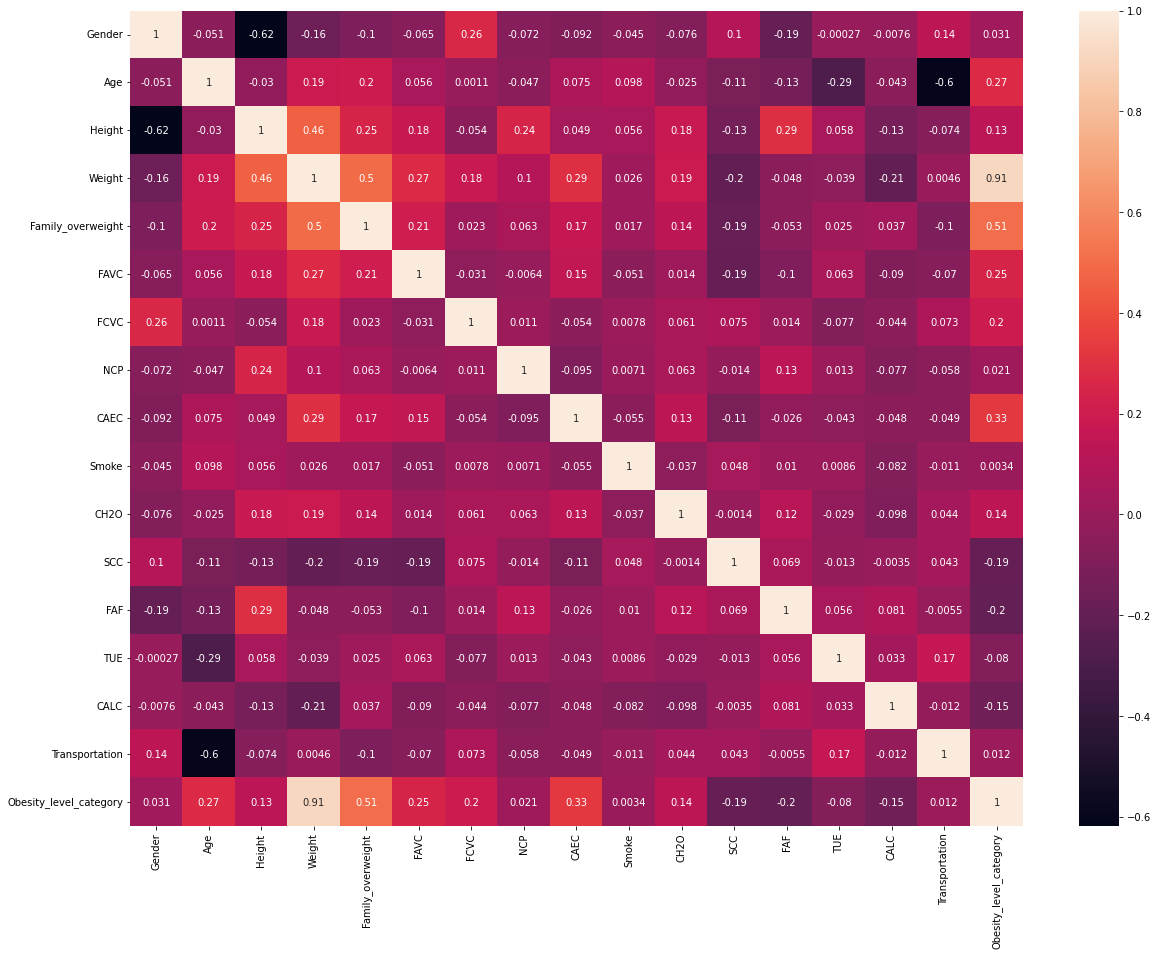

In [364]:
corr_df = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

We notice that the variable Weight is highly correlated with the level of obesity, which is logical since weight is very determinant in determining the level of obesity with the BMI.

We also notice that some variables have very little influence on the level of obesity, which is the case for example with the variables Smoke, Gender, NCP, or even the variable Transportation.

##Distribution of the data

Let us now study the distribution of the data in more details to determine whether certain columns are biased with respect to the representation of a normal population. 

Indeed, if we wish to set up a generalizable study and prediction model, we must work on a sample that is as representative as possible of the reality.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1402906050>,
      dtype=object)

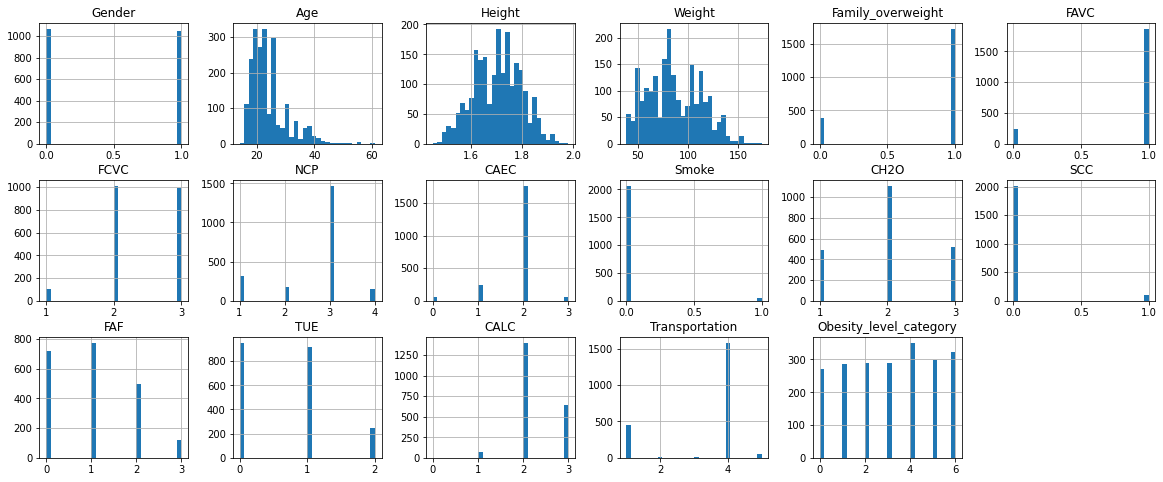

In [365]:
df[col_names].hist(bins=30, figsize=(20, 8), layout=(3, 6))

Although the age curve shows us that the sample is quite young, we see that there are as many men and women of different heights and weights. The sample is well representative of a real population.

Moreover, there is a homogeneous distribution of the different categories of obesity.

###Smoke variable

However, we can notice something quite surprising in the "Smoke" variable:

In [366]:
df.groupby("Smoke").count()["Gender"]

Smoke
0    2067
1      44
Name: Gender, dtype: int64

We can see that 2% of our sample is a smoker, which is not representative of the number of people who smoke in South America. For example, 16% of the adult population smokes in Mexico, which is considerably more. 

Because there are not enough smokers in the sample, we doubt its true impact on obesity in this study, and we decide to remove the variable from the dataset.

In [367]:
df.drop(['Smoke'],axis = 1, inplace = True)

###Transportation variable

We can also observe above a rather uneven distribution in terms of means of transport

In [368]:
df_copie.groupby("MTRANS").count()["Gender"]

MTRANS
Automobile                457
Bike                        7
Motorbike                  11
Public_Transportation    1580
Walking                    56
Name: Gender, dtype: int64

We can see that this variable tells us whether an individual uses a means of transport that requires physical effort (walking or cycling) or not (car, bus or motorbike). In order for this variable to have a greater impact on the prediction of obesity levels, by having a distinct boundary, we have chosen to transform the column by grouping together means of transport requiring physical effort and those not requiring any.

Thus, cars, motorbikes and public transport (categories 1, 3 and 4) will be categorised as 0 as they produce no physical effort, while walking and cycling (categories 2 and 5) will be categorised as 1.

In [369]:
df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

###Pairwise relationships

We are going now, to plot different pairwise relationships in this dataset, in order to see if there are other interesting things to take into account.

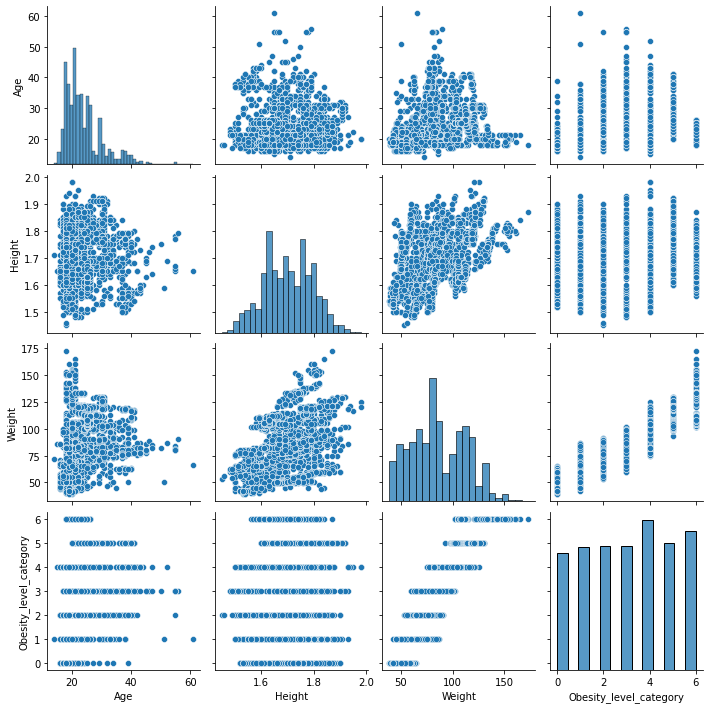

In [370]:
sns.pairplot(df[["Age","Height","Weight","Obesity_level_category"]])

It can be seen that as a person's weight increases, so does their level of obesity. 
Furthermore, height does not influence the level of obesity

This confirms that the IMC, to determine the level of obesity, is calculated from the weight of a person

To allow the models to take more account of the other variables, we have decided to remove the Weight variable from the dataframe.

In [371]:
df.drop(['Weight'],axis = 1, inplace = True)

# Model prediction

x : variables de predictions

y : target variable

In [372]:
# x=df.loc[:,df.columns!="Obesity_level_category"]
# y=df.loc[:,df.columns=="Obesity_level_category"]

Scaling the data

In [373]:
# scaler=StandardScaler()
# scaler.fit(x)
# x_scaled=scaler.transform(x)

Split the data in a train_set and in a test_set

In [374]:
# x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [375]:
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

1.   LDA
2.   Knn
3.   SVM
4.   Random Forest
5.   Boosting

#Linear Discriminant Analysis

##All classes

In [376]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

#df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [377]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

In [378]:
scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [379]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)
x_train

array([[ 1.01191369,  1.58985335, -0.33873962, ...,  0.0855974 ,
         1.4191716 , -0.17539019],
       [-0.98822657, -0.15419354,  0.08977234, ..., -0.78495021,
        -0.52115952, -0.17539019],
       [ 1.01191369,  0.32145561, -0.6601236 , ..., -0.66997222,
        -0.52115952, -0.17539019],
       ...,
       [-0.98822657,  0.48000533,  1.48243624, ...,  0.03632112,
        -0.52115952, -0.17539019],
       [ 1.01191369,  2.38260194, -1.83853151, ..., -1.08060789,
        -0.52115952, -0.17539019],
       [ 1.01191369, -0.15419354,  0.08977234, ...,  2.20447744,
         1.4191716 , -0.17539019]])

In [380]:
parameters = {"solver": ["svd", "lsqr", "eigen"], "shrinkage": ["None", "auto"], "n_components" :["None", 5, 10, 15]}

In [381]:
lda = LinearDiscriminantAnalysis()

Implementation of cross-validation methods to assess the performance of the models:

In [382]:
def validation_curve_function(model, x, y, paramater, k):
  train_scores, val_scores=validation_curve(model,x , y, param_range=k, cv=5, param_name=paramater)
  plt.plot(k, val_scores.mean(axis=1))
  plt.plot(k, train_scores.mean(axis=1))

def cross_val_function(model, x, y):
  print(cross_val_score(model, x, y))

cross_val_function(lda, x_train, y_train)

[0.90459364 0.8975265  0.8869258  0.83745583 0.86524823]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [383]:
grid_search = GridSearchCV(estimator=lda,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [384]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=auto, solver=lsqr;, score=0.823 total time=   0.0s
[CV 2/5] END n_components=5, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV 3/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.830 total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.781 total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.809 total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_comp

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV 2/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=15, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=15, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_co

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': ['None', 5, 10, 15],
                         'shrinkage': ['None', 'auto'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=4)

In [385]:
grid_search.best_params_

{'n_components': 5, 'shrinkage': 'auto', 'solver': 'lsqr'}

In [386]:
lda=LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto", n_components=5)

In [387]:
model_lda=lda.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [388]:
model_lda.coef_

array([[-5.09339571e-01, -1.10336145e+00,  4.03858111e+00,
        -1.76301917e+01, -1.17849222e+00,  4.12219306e-02,
         2.62943627e-01,  3.55397320e-01, -1.18062755e+00,
         1.92643769e-01, -1.50428969e-01,  9.11689646e-01,
         2.62648543e-01,  1.49273384e-01, -7.57609515e-03],
       [-9.15988122e-01, -6.09665519e-01,  2.03892913e+00,
        -1.14724466e+01, -8.25696524e-01, -3.09797881e-01,
        -3.13610445e-01, -9.98430553e-03, -1.28523733e+00,
        -3.83632044e-02, -7.50756906e-02,  8.28274569e-01,
         4.45752082e-04, -1.92752616e-01,  6.39929671e-01],
       [-6.98836247e-02,  3.36413378e-01, -9.55922158e-01,
         3.40918834e+00,  5.61678041e-01,  1.07271347e-01,
        -5.00823395e-01, -4.45759537e-01,  3.33062546e-01,
         8.49952224e-02, -3.85255542e-02, -8.07232261e-02,
         3.22169470e-03,  3.53663330e-01, -1.02951167e-01],
       [-7.50936187e-01,  9.80274867e-01, -2.05105292e+00,
         1.12850946e+01,  4.41327489e-01,  3.30510560

In [389]:
coef_fonctions_de_classement = pd.DataFrame(model_lda.coef_.transpose(), index=df.columns[:-1], columns=model_lda.classes_)
coef_fonctions_de_classement

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Gender,-0.509340,-0.915988,-0.069884,-0.750936,2.813873,-0.190067,-0.648301
Age,-1.103361,-0.609666,0.336413,0.980275,-0.183492,-0.216400,0.685868
Height,4.038581,2.038929,-0.955922,-2.051053,-3.558976,1.073880,0.413515
Weight,-17.630192,-11.472447,3.409188,11.285095,17.505939,-5.651755,-2.244797
Family_overweight,-1.178492,-0.825697,0.561678,0.441327,0.598904,-0.098596,0.393224
FAVC,0.041222,-0.309798,0.107271,0.033051,0.337602,0.271641,-0.498914
FCVC,0.262944,-0.313610,-0.500823,-0.054902,1.278366,-0.333846,-0.293781
NCP,0.355397,-0.009984,-0.445760,-0.097030,0.761281,-0.204754,-0.202751
CAEC,-1.180628,-1.285237,0.333063,0.540913,0.920101,0.377406,0.172945
CH2O,0.192644,-0.038363,0.084995,-0.697910,0.123452,0.139024,0.030015


In [390]:
print(model_lda.intercept_) #constantes des fonctions de classement

[-15.65145101  -8.4863459   -2.72021083  -8.20582059 -16.45695096
  -3.69150183  -2.67354193]


In [391]:
pred = model_lda.predict(x_test)
pd.Series(pred).value_counts()

Overweight_Level_II    124
Obesity_Type_III       118
Obesity_Type_I         106
Obesity_Type_II         98
Overweight_Level_I      91
Insufficient_Weight     91
Normal_Weight           69
dtype: int64

In [392]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_all

83.21377331420373

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.82332155 0.83745583 0.83038869 0.78091873 0.80851064]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

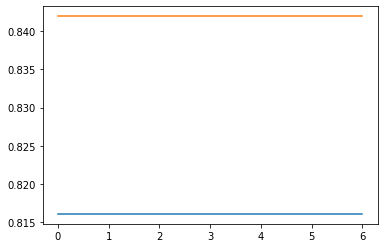

In [393]:
cross_val_function(lda, x_train, y_train)
validation_curve_function(lda, x_train, y_train, "n_components", np.arange(0,16,1))

It is difficult to be very precise with the 7 types of obesity as the dataset contains only 300 data for each type which seems relatively small to generalise the model.

Let's try to simplify the model by trying to predict only if an individual is obese or not.

##Binary classification using logistic regression

We will now try to simply predict whether an individual is obese or not.

We will re-transform the dataset, so that we have only two classes: 

* Obese people (types 1, 2 and 3)
* The others (Underweight, normal, overweight 1 and 2)



In [394]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [395]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)
y["Obesity_level_category"]

0       Not obese
1       Not obese
2       Not obese
3       Not obese
4       Not obese
          ...    
2106        Obese
2107        Obese
2108        Obese
2109        Obese
2110        Obese
Name: Obesity_level_category, Length: 2111, dtype: object

In [396]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [397]:
lg = LogisticRegression()

parameters = {"penalty" : ['l1', 'l2', 'elasticnet', 'none'], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "C": [10, 1.0, 0.1, 0.01]}

In [398]:
cross_val_function(lg, x_train, y_train)

[0.99646643 0.99293286 0.98586572 0.99646643 0.9822695 ]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [399]:
grid_search = GridSearchCV(estimator=lg,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [400]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, penalty=l1, solver=liblinear;, score=1.000 total time=   0.0s
[CV 2/5] END C=10, penalty=l1, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=10, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=0.989 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=0.982 total time=   0.0s
[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.982 total time=   0.0s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=1.000 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.989 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=liblinear;, score=0.982 total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/d

[CV 2/5] END C=10, penalty=none, solver=newton-cg;, score=1.000 total time=   0.1s
[CV 3/5] END C=10, penalty=none, solver=newton-cg;, score=0.989 total time=   0.1s
[CV 4/5] END C=10, penalty=none, solver=newton-cg;, score=0.986 total time=   0.1s
[CV 5/5] END C=10, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 1/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END ..C=10, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d


[CV 3/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.986 total time=   0.0s
[CV 5/5] END ..C=10, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 1/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=1.0, penalt

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, wa

[CV 1/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.993 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.986 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.982 total time=   0.0s
[CV 1/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.993 total time=   0.0s
[CV 3/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.986 total time=   0.0s
[CV 4/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.982 total time=   0.0s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.993 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.986 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.982 total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan tota

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.989 total time=   0.1s
[CV 4/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.986 total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 1/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END .C=1.0, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.986 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .C=1.0, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 1/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END .....C=0.1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .....C=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.982 total time=   0.0s
[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.993 total time=   0.0s
[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.975 total time=   0.0s
[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.975 total time=   0.0s
[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.982 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.979 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.979 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.979 total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 2/5] END C=0.1, penalty=none, solver=newton-cg;, score=1.000 total time=   0.1s
[CV 3/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.989 total time=   0.1s
[CV 4/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.986 total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 1/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END .C=0.1, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.986 total time=   0.0s
[CV 5/5] END .C=0.1, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 1/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, pe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.936 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.915 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.954 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.936 total time=   0.0s
[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.912 total time=   0.0s
[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.936 total time=   0.0s
[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.915 total time=   0.0s
[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.954 total time=   0.0s
[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.936 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.915 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.947 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.905 total time=   0.0s
[CV 4/5] END C

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 4/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.986 total time=   0.1s
[CV 5/5] END C=0.01, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.986 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=4)

In [401]:
grid_search.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [402]:
lg = LogisticRegression(penalty='l2', C=0.01, solver='newton-cg')

In [403]:
model_lg = lg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [404]:
pred = model_lg.predict(x_test)
pd.Series(pred).value_counts()

Not obese    364
Obese        333
dtype: int64

In [405]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_bin

94.11764705882354

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

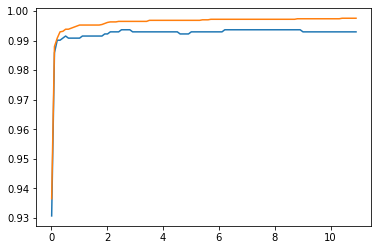

In [406]:
validation_curve_function(LogisticRegression(), x_train, y_train, "C", np.arange(0.01,11,0.1))

The logistic regression allows us to determine at 77% whether a person is obese or not.


The accuracy of the model increased by about 23% using only the 2 class model. 

This increase in accuracy is explained by the fact that when we had 7 different classes in the data set the boundaries between classes were not precise because the data overlapped and therefore the model was wrong on a large part of the predictions. 

However, by simplifying the model and grouping them into only 2 classes the algorithm is able to distinguish the boundaries between classes better and better.

#Knn

We will now try to use the K-nearest neighbors algorithm to see if we can increase the accuracy of predictions.

##All classes

In [407]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

#df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [408]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [409]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [410]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [411]:
cross_val_function(knn, x_train, y_train)

[0.79151943 0.77031802 0.77738516 0.79151943 0.76241135]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [412]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [413]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.806 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.784 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.774 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.766 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.827 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.787 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.792 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.770 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.777 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.792 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.762 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.837 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.809 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.816 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.791 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.763 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.770 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.752 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.816 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.784 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.780 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.760 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.738 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.816 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.767 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.777 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.784 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.735 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.731 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.714 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.734 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.813 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.784 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.777 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.749 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.717 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.728 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.728 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.727 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.802 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.760 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.766 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.735 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.703 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.724 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.714 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.734 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.756 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.792 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.753 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.675 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.710 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.714 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.748 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.792 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.746 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.770 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.731 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.686 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.730 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.742 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.763 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.759 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.830 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.802 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.852 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.834 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.805 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.852 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.806 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.873 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.848 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.826 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.834 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.813 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.852 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.816 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.880 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.813 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.873 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.841 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.840 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.834 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.784 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.845 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.816 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.830 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.806 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.876 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.823 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.855 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.823 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.784 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.823 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.801 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.799 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.855 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.834 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.848 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.816 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.823 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.773 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.813 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.855 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.823 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.826 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.777 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.806 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.777 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.777 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.852 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.848 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.809 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.812 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.777 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.753 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.802 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.784 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.777 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.845 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.799 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.848 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.816 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.819 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.767 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.742 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.777 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.777 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.766 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.855 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.781 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.830 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.812 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.763 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.735 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.767 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.770 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.745 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.841 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.788 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.827 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.816 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.806 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.784 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.774 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.766 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.827 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.787 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.792 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.770 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.777 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.792 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.762 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.837 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.809 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.816 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.791 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.763 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.770 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.752 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.816 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.784 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.780 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.760 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.738 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.816 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.767 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.777 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.784 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.735 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.731 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.714 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.734 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.813 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.784 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.777 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.749 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.717 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.728 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.728 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.727 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.802 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.760 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.766 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.735 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.703 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.724 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.714 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.734 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.756 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.792 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.753 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.675 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.710 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.714 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.748 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.792 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.746 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.770 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.731 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.686 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.730 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.742 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.763 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.759 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [414]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [415]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [416]:
model_knn_all = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [417]:
pred = model_knn_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         121
Obesity_Type_III       106
Overweight_Level_I     104
Obesity_Type_II        102
Overweight_Level_II     99
Insufficient_Weight     99
Normal_Weight           66
dtype: int64

In [418]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_all

85.65279770444764

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

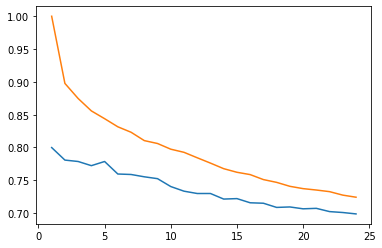

In [419]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

We obtained 82% success in predicting the different types of obesity, which is significantly better than with the LDA model performed above.

Indeed, as the data overlap between the different classes, it is much more efficient and coherent to study the neighbours of an individual in space than to try to draw a border between the different classes.

##Classification binaire

In [420]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [421]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [422]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [423]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [424]:
cross_val_function(knn, x_train, y_train)

[0.92932862 0.9434629  0.96466431 0.93639576 0.94680851]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [425]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [426]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.947 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.968 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.957 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.936 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.951 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.968 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.940 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.961 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.929 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.943 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.965 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.936 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.947 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.947 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.968 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.943 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.965 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.929 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.947 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.947 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.922 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.961 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.943 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.929 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.943 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.965 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.915 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.905 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.929 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.922 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.929 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.951 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.951 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.958 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.936 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.905 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.915 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.940 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.918 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.929 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.940 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.951 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.933 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.940 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.940 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.958 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.926 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.943 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.954 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.954 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.968 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.961 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.961 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.958 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.968 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.936 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.972 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.947 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.968 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.975 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.947 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.961 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.954 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.972 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.975 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.947 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.972 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.951 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.958 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.940 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.972 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.958 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.972 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.954 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.975 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.954 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.975 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.929 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.954 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.947 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.972 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.979 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.951 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.968 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.940 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.943 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.972 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.915 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.943 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.965 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.979 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.943 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.965 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.919 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.940 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.961 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.961 total time=   0.0s

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam


[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.936 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.919 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.968 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.901 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.936 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.951 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.954 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.975 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.936 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.919 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.951 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.912 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.954 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.936 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.961 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.936 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.943 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.905 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.929 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.947 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.951 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.965 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.936 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.947 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.968 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.957 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.936 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.951 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.968 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.961 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.929 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.943 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.936 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.947 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.947 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.968 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.943 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.929 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.947 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.947 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.961 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.943 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.972 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.929 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.908 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.943 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.965 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.947 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.915 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.905 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.922 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.929 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.951 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.951 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.912 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.958 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.936 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.905 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.915 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.940 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.908 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.918 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.929 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.951 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.940 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.940 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.958 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.926 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.943 total time=   0.0s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [427]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [428]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [429]:
model_knn_bin = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [430]:
pred = model_knn_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    360
Obese        337
dtype: int64

In [431]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_bin

95.6958393113343

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

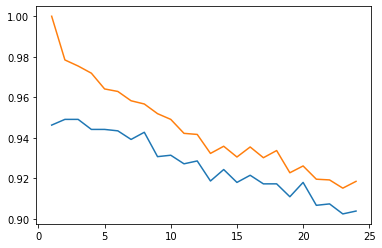

In [432]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

With the Knn we obtain 92.5% of success on the classification which confirms the conclusion made during the first test of the Knn on all the classes of the dataset.

#SVM

##All classes

In [433]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

#df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [434]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [435]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [436]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [437]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.81978799 0.86572438 0.89045936 0.83038869 0.84751773]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [438]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [439]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.845 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.894 total time=   0.1s
[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.845 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s
[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.883 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.912 total time=   0.1s
[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.911 total time=   0.1s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.1s
[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.572 total time=   0.1s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.572 total time=   0.1s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.567 total time=   0.1s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.845 total time=   0.1s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.894 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.848 total time=   0.1s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.912 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.911 total time=   0.1s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.583 total time=   0.1s
[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.572 total time=   0.1s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.553 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.855 total time=   0.1s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.894 total time=   0.1s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.848 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.858 total time=   0.1s
[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s
[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.911 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.1s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.604 total time=   0.1s
[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.562 total time=   0.1s
[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.534 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.546 total time=   0.1s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.890 total time=   0.1s
[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.848 total time=   0.1s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.883 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.911 total time=   0.1s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.1s
[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.572 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.562 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.562 total time=   0.1s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.553 total time=   0.1s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.852 total time=   0.1s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.880 total time=   0.1s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.837 total time=   0.1s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.844 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.912 total time=   0.1s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.905 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.918 total time=   0.1s
[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.555 total time=   0.1s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.555 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.567 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.852 total time=   0.1s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.880 total time=   0.1s
[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.837 total time=   0.1s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.848 total time=   0.1s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.912 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.905 total time=   0.1s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.918 total time=   0.1s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.1s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.541 total time=   0.1s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.578 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.834 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.876 total time=   0.1s
[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.866 total time=   0.1s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.813 total time=   0.1s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.851 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.873 total time=   0.1s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.866 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.904 total time=   0.1s
[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.1s
[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.599 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.834 total time=   0.1s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.876 total time=   0.1s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.816 total time=   0.1s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.851 total time=   0.1s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.904 total time=   0.1s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s
[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.576 total time=   0.1s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.599 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.760 total time=   0.1s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.753 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.805 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.820 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.866 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.848 total time=   0.1s
[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.608 total time=   0.1s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.625 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.654 total time=   0.1s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.640 total time=   0.1s
[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.642 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.774 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.756 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.784 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.805 total time=   0.1s
[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.820 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.869 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.848 total time=   0.1s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.640 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.643 total time=   0.1s
[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.642 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.551 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.572 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.519 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.530 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.574 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.668 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.678 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.657 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.643 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.691 total time=   0.1s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.569 total time=   0.1s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.596 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.583 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.587 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.534 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.534 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.578 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.664 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.678 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.661 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.643 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.695 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.2s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.576 total time=   0.2s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.596 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.219 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.219 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.191 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.216 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.223 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s
[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s
[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.180 total time=   0.2s
[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.184 total time=   0.2s
[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.174 total time=   0.2s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.223 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.219 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.191 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.216 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.223 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.184 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.187 total time=   0.2s
[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [440]:
grid_search.best_params_

{'C': 25, 'gamma': 'auto', 'kernel': 'rbf'}

In [441]:
svm_svc = SVC(C=25, gamma='scale', kernel='rbf')
model_svm_all = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [442]:
pred = model_svm_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_III       114
Obesity_Type_I         109
Normal_Weight          104
Overweight_Level_II    101
Insufficient_Weight     92
Overweight_Level_I      89
Obesity_Type_II         88
dtype: int64

In [443]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_all

92.39598278335724

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

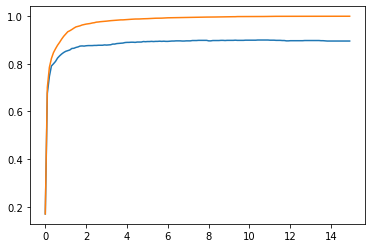

In [444]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

78% success rate.

##Binary classification

In [445]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [446]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [447]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [448]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [449]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.97526502 0.99646643 0.98233216 0.97879859 0.9787234 ]


In [450]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [451]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.972 total time=   0.0s
[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.855 total time=   0.0s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.869 total time=   0.0s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.879 total time=   0.0s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.972 total time=   0.0s
[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.859 total time=   0.0s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.873 total time=   0.0s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.879 total time=   0.0s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s
[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.855 total time=   0.0s
[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.894 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.873 total time=   0.0s
[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.852 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.912 total time=   0.0s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.865 total time=   0.0s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.961 total time=   0.0s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.859 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.859 total time=   0.0s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.894 total time=   0.0s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.873 total time=   0.0s
[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.865 total time=   0.0s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.961 total time=   0.0s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.866 total time=   0.0s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.972 total time=   0.0s
[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.982 total time=   0.0s
[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.855 total time=   0.0s
[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.873 total time=   0.0s
[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.865 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.968 total time=   0.0s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=1.000 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.982 total time=   0.0s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.859 total time=   0.0s
[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.866 total time=   0.0s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.883 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.865 total time=   0.0s
[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.958 total time=   0.0s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.986 total time=   0.0s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.972 total time=   0.0s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.957 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.975 total time=   0.0s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.996 total time=   0.0s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.982 total time=   0.0s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.979 total time=   0.0s
[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.887 total time=   0.1s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.908 total time=   0.0s
[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.876 total time=   0.0s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.954 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.989 total time=   0.0s
[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.972 total time=   0.0s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.957 total time=   0.0s
[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.979 total time=   0.0s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.982 total time=   0.0s
[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.979 total time=   0.0s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.890 total time=   0.0s
[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.912 total time=   0.0s
[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.876 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.799 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.827 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.781 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.922 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.954 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.926 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.919 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.926 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.919 total time=   0.1s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.926 total time=   0.1s
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.908 total time=   0.1s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.894 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.795 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.823 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.781 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.859 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.801 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.922 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.958 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.926 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.919 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.926 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.915 total time=   0.1s
[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.926 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.915 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.890 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.576 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.551 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.638 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.735 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.799 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.767 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.749 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.801 total time=   0.1s
[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.848 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.848 total time=   0.1s
[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.862 total time=   0.1s
[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.851 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.548 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.537 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.544 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.548 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.571 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.735 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.799 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.774 total time=   0.1s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.749 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.801 total time=   0.1s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.848 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.848 total time=   0.1s
[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.834 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.862 total time=   0.1s
[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.848 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [452]:
grid_search.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [453]:
svm_svc = SVC(C=50, gamma='scale', kernel='rbf')
model_svm_bin = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [454]:
pred = model_svm_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    385
Obese        312
dtype: int64

In [455]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_bin

98.56527977044476

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

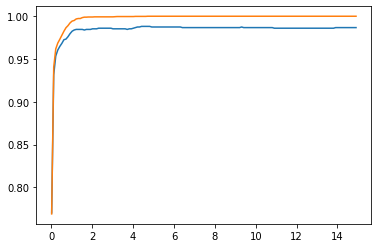

In [456]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

91.7% success rate.

#Random Forest


##All classes

In [457]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

#df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [458]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [459]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [460]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 500], "max_features" : ['sqrt', 'log2']}

In [461]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.93992933 0.92579505 0.93639576 0.95759717 0.93262411]


In [462]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [463]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.901 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.915 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.894 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.915 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.908 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.947 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.933 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.936 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.951 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=500;, score=0.947 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=500;, score=0.926 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=500;, score=0.940 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=500;, score=0.958 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=500;, score=0.940 total time=   1.2s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.912 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.933 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.901 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.922 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.915 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.951 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=100;, score=0.926 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=100;, score=0.940 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.958 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.933 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=500;, score=0.951 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=500;, score=0.926 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=500;, score=0.943 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=500;, score=0.954 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=500;, score=0.936 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [464]:
best_par = grid_search.best_params_
best_par

{'max_features': 'sqrt', 'n_estimators': 500}

In [465]:
RF = RandomForestClassifier(max_features = best_par["max_features"], n_estimators = best_par["n_estimators"])
model_RF_all = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [466]:
pred = model_RF_all.predict(x_test)
pd.Series(pred).value_counts()

Normal_Weight          116
Obesity_Type_I         112
Obesity_Type_II        111
Obesity_Type_III        99
Insufficient_Weight     89
Overweight_Level_II     88
Overweight_Level_I      82
dtype: int64

In [467]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_all

93.83070301291248

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

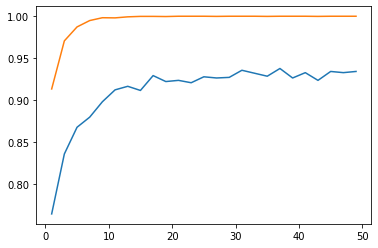

In [468]:
validation_curve_function(RandomForestClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

The Random Forest model allows us to determine at 84% whether a person is obese or not.

##Binary classification

In [469]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [470]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [471]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [472]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 500], "max_features" : ['sqrt', 'log2']}

In [473]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.97879859 0.97526502 0.99293286 0.98233216 0.9893617 ]


In [474]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [475]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.975 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.972 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.986 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.982 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.979 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.986 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=500;, score=0.979 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=500;, score=0.986 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=500;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=500;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=500;, score=0.993 total time=   1.0s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.975 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.979 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.975 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.989 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.979 total time=   0.2s
[CV 2/5] END max_features=log2, n_estimators=100;, score=0.982 total time=   0.2s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV 3/5] END max_features=log2, n_estimators=100;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.986 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=500;, score=0.979 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=500;, score=0.986 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=500;, score=0.993 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=500;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=500;, score=0.993 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [476]:
best_par = grid_search.best_params_
best_par

{'max_features': 'log2', 'n_estimators': 500}

In [477]:
RF = RandomForestClassifier(max_features = best_par["max_features"], n_estimators = best_par["n_estimators"])
model_RF_bin = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [478]:
pred = model_RF_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    389
Obese        308
dtype: int64

In [479]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_bin

99.13916786226686

The accuracy of the model is now 93%.

It has increased by about 9% using only the 2 class model.

#Gradient Boosting Classifier

##All classes

In [480]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

#df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [481]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [482]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [483]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 500], "learning_rate" : [0.001, 0.01, 0.1]}

In [484]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[0.95053004 0.94699647 0.96466431 0.96113074 0.95390071]


In [485]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [486]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s
[CV 3/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s
[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.633 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.657 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.678 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.700 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.674 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=500;, score=0.788 total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=500;, score=0.788 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=500;, score=0.788 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=500;, score=0.806 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=500;, score=0.784 total time=   8.0s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.643 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.654 total time=   0.2s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.678 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.700 total time=   0.2s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.674 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.823 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.830 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.845 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.848 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.872 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=500;, score=0.940 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=500;, score=0.947 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=500;, score=0.965 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=500;, score=0.940 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=500;, score=0.940 total time=   8.1s
[CV 1/5] END learning_rate=0.1, n_estimators=10;, score=0.827 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=10;, score=0.834 total time=   0.2s
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=0.855 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=10;, score=0.841 total time=   0.2s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=0.879 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.951 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.951 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.965 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.961 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.954 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=500;, score=0.951 total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=500;, score=0.943 total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=500;, score=0.968 total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=500;, score=0.951 total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=500;, score=0.957 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [487]:
best_par = grid_search.best_params_
best_par

{'learning_rate': 0.1, 'n_estimators': 100}

In [488]:
boost = GradientBoostingClassifier(learning_rate = best_par["learning_rate"], n_estimators = best_par["n_estimators"])
model_boost_all = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [489]:
pred = model_boost_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         106
Overweight_Level_I     106
Normal_Weight          101
Obesity_Type_III        99
Obesity_Type_II         97
Overweight_Level_II     96
Insufficient_Weight     92
dtype: int64

In [490]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_all

97.27403156384506

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

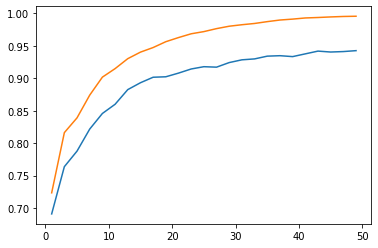

In [491]:
validation_curve_function(GradientBoostingClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

The Gradient Boosting Classifier allows us to determine at 79% whether a person is obese or not.

##Binary Classification

In [492]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [493]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [494]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [495]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 500], "learning_rate" : [0.001, 0.01, 0.1], "subsample" : [0.5, 0.7, 1.0], "max_depth" : [3, 7, 9]}

In [496]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[1.         0.99646643 0.98939929 0.99646643 0.9964539 ]


In [497]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [498]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.539 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.539 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.539 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.919 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.954 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.912 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.915 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.965 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.943 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.961 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.908 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.915 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.954 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.972 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.965 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.922 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.912 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.954 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.982 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.982 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.989 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.968 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.968 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.972 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.979 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.968 total time=   1.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.539 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.539 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.539 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.972 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.979 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.989 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.979 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.975 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.982 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.979 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.979 total time=   1.6s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.539 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.539 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.541 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.537 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.539 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.961 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.986 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.965 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.979 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.993 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.993 total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.993 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.982 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=1.000 total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.986 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.979 total time=   1.7s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.947 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.958 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.905 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.915 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.954 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.940 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.961 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.912 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.915 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.950 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.972 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.965 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.922 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.912 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.954 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.982 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.979 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.972 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.989 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.968 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.968 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.996 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.989 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.996 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.986 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.996 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.986 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.996 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.996 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.979 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.975 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.986 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.989 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.986 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.968 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.975 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.975 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.986 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.979 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.986 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.989 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.986 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.993 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.979 total time=   1.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.975 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.968 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.979 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.968 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.968 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.989 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=1.000 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=1.000 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.996 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.996 total time=   1.0s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.989 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.986 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.989 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.986 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.975 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.986 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.979 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 7, 9], 'n_estimators': [10, 100, 500],
                         'subsample': [0.5, 0.7, 1.0]},
             verbose=4)

In [499]:
best_par = grid_search.best_params_
best_par

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}

In [500]:
boost = GradientBoostingClassifier(learning_rate = best_par["learning_rate"], n_estimators = best_par["n_estimators"], max_depth = best_par["max_depth"], subsample = best_par["subsample"])
model_boost_bin = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [501]:
pred = model_boost_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    379
Obese        318
dtype: int64

In [502]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_bin

99.4261119081779

The accuracy of the model is now 94%.

It has increased by about 17% using only the 2 class model.

#Comparaison of the models

In [503]:
res_all = [res_lda_all, res_knn_all, res_svm_all, res_rf_all, res_boost_all]
res_bin = [res_lda_bin, res_knn_bin, res_svm_bin, res_rf_bin, res_boost_bin]
results = np.array([res_all, res_bin])

names_models = ["Linear Discriminant Analysis","Knn","SVM","Random Forest","Boosting"]
compare_models = pd.DataFrame(results, index=["All classes","Binary Classification"], columns = names_models)
compare_models

,Linear Discriminant Analysis,Knn,SVM,Random Forest,Boosting
All classes,83.213773,85.652798,92.395983,93.830703,97.274032
Binary Classification,94.117647,95.695839,98.565280,99.139168,99.426112


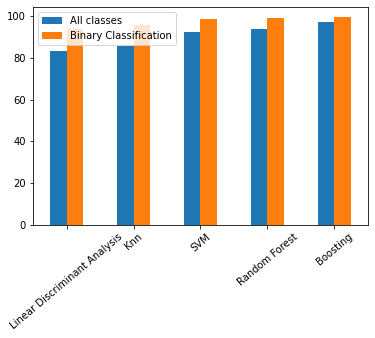

In [504]:
compare_models.T.plot(kind="bar",rot=40)

#Flask

##Conversion des informations input, sous forme d'un dataframe conforme aux différents modèles 

Voici, une fonction qui nous permet de transformer les données issues du formulaire sur la page web, en données prêtes à être envoyé dans la fonction de prédiction de nos différents modèlesd eMachine Learning.

In [520]:
def Create_data_for_prediction(data):
  col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]

  df = pd.DataFrame([data],columns=col_names)

  df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
  df["Age"] = df["Age"].apply(lambda x : int(x))
  df["Height"] = df["Height"].apply(lambda x : round(float(x),2))
  df["Weight"] = df["Weight"].apply(lambda x : round(float(x),1))
  df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FCVC"] = df["FCVC"].apply(lambda x : int(round(int(x),0)))
  df["NCP"] = df["NCP"].apply(lambda x : int(round(int(x),0)))
  df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
  df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
  df["CH2O"] = df["CH2O"].apply(lambda x : round(int(x),1))
  df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAF"] = df["FAF"].apply(lambda x : int(round(int(x),0)))
  df["TUE"] = df["TUE"].apply(lambda x : round(int(x),2))
  df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

  transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

  df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

  df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
  df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
  df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

  df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
  df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

  #df.drop(['Weight'],axis = 1, inplace = True)
  df.drop(['Smoke'],axis = 1, inplace = True)

  x=df.loc[:,df.columns!="Obesity_level_category"]

  scaler=StandardScaler()
  scaler.fit(x)
  x_scaled=scaler.transform(x)

  return x_scaled 

##Pip install and packages

In [506]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 22jg9dgfJ2Vrf9hIs8I8fppLe24_4vre3wAhAg3T7F9ArM2Nr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [507]:
import pickle
from os import name
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, redirect, url_for

Sauvegarde de nos modèles au format .pkl pour l'application Flask

In [508]:
pickle.dump(model_RF_all, open('model_RF_all.pkl','wb'))
pickle.dump(model_RF_bin, open('model_RF_bin.pkl','wb'))

##App

In [ ]:
app = Flask(__name__, template_folder='/content', static_folder='/content/static')

run_with_ngrok(app)

model_RF_all = pickle.load(open('/content/model_RF_all.pkl', 'rb'))
model_RF_bin = pickle.load(open('/content/model_RF_bin.pkl', 'rb'))


@app.route('/')
def home():
    return render_template("index_accueil.html")

@app.route('/Binary_prediction',methods=['POST'])
def Binary_prediction(): 
  return render_template("binary_classification.html")

@app.route('/All_classes_prediction',methods=['POST'])
def All_classes_prediction(): 
  return render_template("all_classes.html")

@app.route('/get_binary_prediction',methods=['POST'])
def get_binary_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = model_RF_bin.predict(x)

    return render_template("binary_classification.html", output='Predicted obesity level category : {}'.format(prediction))

@app.route('/get_all_classes_prediction',methods=['POST'])
def get_all_classes_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = model_RF_all.predict(x)

    return render_template("all_classes_result.html", output='Predicted obesity level category : {}'.format(prediction))

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://14f6-35-185-151-22.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [30/Dec/2021 03:31:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2021 03:31:09] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2021 03:31:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2021 03:31:10] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2021 03:31:10] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [30/Dec/2021 03:31:16] "POST /All_classes_prediction HTTP/1.1" 200 -
